In [1]:
import numpy as np
from PIL import Image

class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3
        
    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2
    
    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

        
    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):
    
    
    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool)
    mask = np.zeros((nx, ny), dtype=np.bool)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1
    
    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)
    
            m = np.zeros((nx, ny), dtype=np.bool)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h
            
        label[mask, 2] = 1
        
        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))
    
    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)
    
    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
nx = 768
ny = 768

In [4]:
generator = GrayScaleDataProvider(nx, ny, cnt=20)

In [5]:
x_test, y_test = generator(1)

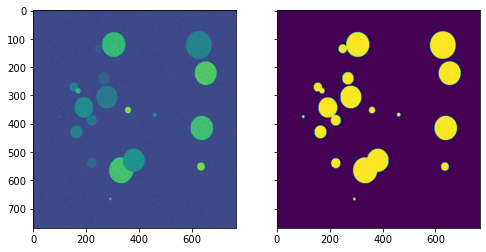

In [6]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

In [7]:
y_test[0,...,1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
#save img and mask sep

# for i in range(256):
#     x_test, y_test = generator(1)
#     plt.imsave(f'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/imgs/Img_{i}.png', x_test[0,...,0])
#     plt.imsave(f'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/masks/Mask_{i}.png', y_test[0,...,1])
    
#     break

In [9]:
# from itertools import groupby

# def binary_mask_to_rle(binary_mask):
#     rle = {'counts': [], 'size': list(binary_mask.shape)} 
#     counts = rle.get('counts')
#     for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
#         if i == 0 and value == 1:
#             counts.append(0)
#         counts.append(len(list(elements)))
#     rle = rle['counts']
#     return rle

In [10]:
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    runs[::2] -= 1
    return ' '.join(str(x) for x in runs)

In [11]:
# test_list_1 = np.array([0, 0, 1, 1, 1, 0, 1])
# test_list_2 = np.array([1, 1, 1, 1, 1, 1, 0])

# print(binary_mask_to_rle(test_list_1))
# print(binary_mask_to_rle(test_list_2))

In [12]:
with open('D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/rle_masks.csv','w') as f:
    f.write('ImageId,EncodedPixels\n')
    f.close()

for i in range(2048):
    x_test, y_test = generator(1)
    rle_str = rle_encode(y_test[0,...,1])
    plt.imsave(f'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/imgs/Img_{i}.jpg', x_test[0,...,0])
    plt.imsave(f'D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/masks/Mask_{i}.jpg', y_test[0,...,1])

    with open('D:/Backup/Курс Нетология/Глубокое обучение/10 CV 2/dll_hw_9_CV_2/data/rle_masks.csv','a') as f:
        f.write(f'Img_{i}.jpg,{rle_str}\n') #Give your csv text here.
        ## Python will convert \n to os.linesep
        f.close()
    
#     break